# Aufgabe 1: Eckendetektion
In der Vorlesung haben Sie den *Harris-Eckendetektor* zum Auffinden von Eckpunkten in Bildern kennengelernt.
Zu diesem Zweck werden zunächst mithilfe eines geeigneten Kantenfilters (z. B. Sobel) die horizontalen und vertikalen Gradienten $G_x, G_y$ des Bildes $I$ berechnet.
Dann wird ein Fenster der Größe $m \times m$ über das Bild geschoben und in jedem Fenster die *Strukturmatrix* $C$ über die Gradienten innerhalb dieses Fensters berechnet:

$$
    C = \begin{pmatrix}
        \sum G_x G_x & \sum G_x G_y \\
        \sum G_y G_x & \sum G_y G_y \\
    \end{pmatrix} \,.
$$

Der kleinere der beiden Eigenwerte dieser Matrix kann dann als Indikator dafür betrachtet werden, mit welcher Wahrscheinlichkeit sich innerhalb dieses Fensters eine Ecke befindet.
Die Anwendung eines geeigneten Schwellwerts liefert sämtliche Kandidaten für eine Ecke.

Abschließend müssen noch redundante Ausschläge für dieselbe Ecke in der so erhaltenen Matrix von Eckenindikatoren unterdrückt werden.
Dazu werden all jene Eckenkandidaten eliminiert, die sich innerhalb eines gewissen Radius von einem anderen Kandidaten mit einer stärkeren Indikation befinden.

Implementieren Sie dieses Verfahren und testen Sie es auf einem geeigneten Beispiel!
Zeichnen Sie die gefundenen Ecken dazu in das Bild ein.
Wie wirken sich verschiedene Fenstergrößen auf das Ergebnis aus?

## 0. Pfade, Pakete etc.

In [3]:
import glob

%matplotlib inline
import matplotlib.pyplot as plt

import imageio
import numpy as np
import math
import scipy.ndimage

In [4]:
image_path = 'Bilder/Checkerboard.jpg'

## 1. Laden des Bildes

In [5]:
image = imageio.imread(image_path)

Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [6]:
image = np.asarray(image, dtype = np.float32) / 255

Schauen wir uns erstmal das Bild an:

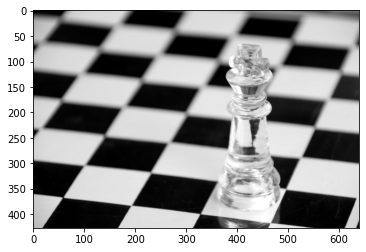

In [7]:
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.show()

## 2. Kantenbild berechnen
Für die Eckendetektion benötigen wir die Gradienten des Bildes entlang der x- und der y-Achse. Nutzen Sie daher einen geeigneten Kantenfilter (z. B. Sobel), um diese Gradienten zu ermitteln. Zur Durchführung der Faltung können Sie die Funktion `scipy.ndimage.convolve` verwenden.

In [8]:
sobel_x = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])
sobel_y = sobel_x.T
edges_x = scipy.ndimage.convolve(image, sobel_x)
edges_y = scipy.ndimage.convolve(image, sobel_y)


Visualisieren Sie nun die Gradienten:

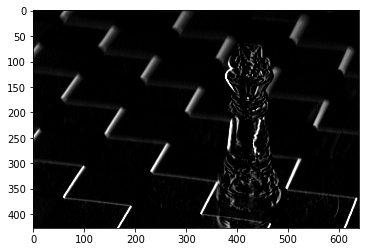

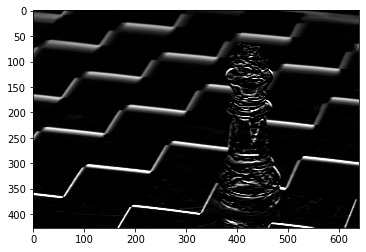

In [9]:
plt.imshow(edges_x, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.imshow(edges_y, cmap='gray', vmin=0, vmax=1)
plt.show()

## 3. Eckenstärken berechnen
Implementieren Sie nun eine Funktion, die in jedem Punkt des Bildes den kleineren Eigenwert der Strukturmatrix in einer $m \times m$-Nachbarschaft berechnet. Dieser dient als Indikator für das Vorhandensein einer Ecke.

Als Eingabe erhält die Funktion die beiden zuvor berechneten Gradienten sowie die Größe der Nachbarschaft.
Die Ausgabe soll ein Array in der Größe des Bildes sein, welches an jeder Pixelkoordinate den kleineren Eigenwert der entsprechenden Strukturmatrix enthält.

Zur Berechnung der Eigenwerte einer symmetrischen Matrix kann die Funktion `np.linalg.eigvalsh` verwendet werden.

In [20]:
def struct_matrix(f_xx, f_xy, f_yy, m, x_center, y_center):
    image_shape = f_xx.shape
    # make a block for the region we need
    x_start = max(x_center - m//2, 0)
    y_start = max(y_center - m//2, 0)
    x_end = min(x_center + m//2 + 1, image_shape[1])
    y_end = min(y_center + m//2 + 1, image_shape[0])
    # mask to only get the values we need (values around the center)
    mask = np.zeros(image_shape, dtype=bool)
    mask[y_start : y_end, x_start : x_end] = True
    # sum up all the things individually
    sum_xx = np.sum(f_xx[mask])
    sum_xy = np.sum(f_xy[mask])
    sum_yy = np.sum(f_yy[mask])
    
    return np.array([
        [sum_xx, sum_xy],
        [sum_xy, sum_yy]
    ])


def ex5_corner_scores(edges_x, edges_y, m):
    scores = np.zeros_like(edges_x)
    f_xx = edges_x * edges_x
    f_xy = edges_x * edges_y
    f_yy = edges_y * edges_y
    for y in range(scores.shape[0]):
        for x in range(scores.shape[1]):
            c_matrix = struct_matrix(f_xx, f_xy, f_yy, m, x, y)
            eigen = np.linalg.eigvalsh(c_matrix)
            scores[y, x] = min(eigen)
    return scores


Nun nutzen wir obige Funktion zur Berechnung der Eckenstärken und stellen Sie diese als Bild dar.

In [21]:
%%time
# %time does not work that well in jupyter vscode
scores = ex5_corner_scores(edges_x, edges_y, m=3)

CPU times: user 53.7 s, sys: 9.09 ms, total: 53.7 s
Wall time: 53.7 s


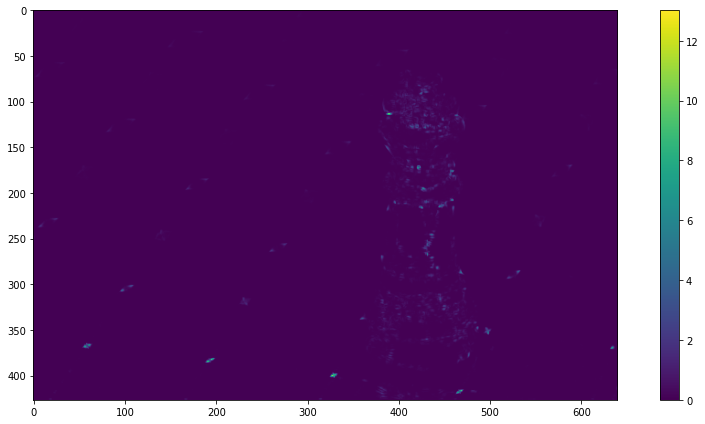

In [22]:
plt.figure(figsize=(12,6))
plt.imshow(scores)
plt.colorbar()
plt.tight_layout()
plt.show()

## 4. Eckendetektion
Um einzelne Ecken zu detektieren, müssen wir nun einen geeigneten Schwellwert auf Eckenstärken-Array anwenden sowie redundante Ausschläge innerhalb eines bestimmten Radius um eine bereits gefundene Ecke herum unterdrücken.

Implementieren Sie zu diesem Zweck die Funktion `ex5_detect_corners`, welche das oben berechneten Eckenstärken-Array, einen Threshold und einen Radius für die Non-Maximum-Suppression übergeben bekommt und eine Liste von $(x, y, s)$-Tupeln zurückgibt. Dabei bezeichnen $x$ und $y$ die Koordinaten der Ecke und $s$ ihre Stärke.

In [25]:
def ex5_detect_corners(scores, th, radius):
    overthreshold = []
    for y in range(scores.shape[0]):
        for x in range(scores.shape[1]):
            if scores[y][x] >= th:
                overthreshold.append((x, y, scores[y][x]))
    # sort by scores
    overthreshold.sort(key=lambda tuple: tuple[2])
    corners = []
    deleted = []
    for point_0, (x_0, y_0, score_0) in enumerate(overthreshold):
        if point_0 in deleted:
            continue
        corners.append((x_0, y_0, score_0))
        for point_1, (x_1, y_1, score_1) in enumerate(overthreshold):
            if (x_0 - x_1)**2 + (y_0 - y_1)**2 <= radius**2:
                deleted.append(point_1)
    return corners

In [26]:
%%time
# %time does not work that well in jupyter vscode
corners = ex5_detect_corners(scores, th=0.1*scores.max(), radius=20)
print(f'Found {len(corners)} corners.')

Found 41 corners.
CPU times: user 553 ms, sys: 119 µs, total: 553 ms
Wall time: 548 ms


Stellen Sie nun die detektierten Ecken graphisch dar, indem Sie diese in das Bild einzeichnen.

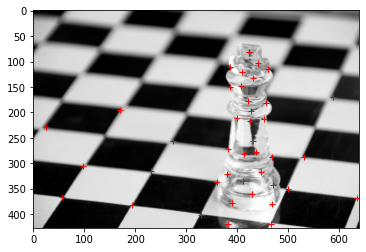

In [27]:
for i in range(len(corners)):
    plt.plot(corners[i][0], corners[i][1], 'r+')
plt.imshow(image, cmap="gray")

## 5. Fenstergröße

Wie wirken sich verschiedene Fenstergrößen auf das Ergebnis aus?

Je größer die jeweilgen Fenster, desto größer werden die Flächen um einen Potentiellen Eckpunkt. d.h. mehr Punkte werden zu einem tatsächlichen Eckpunkt als potentielle Eckpunkte deklariert. 
Dadurch wird die Kantendetektion ggf. ungenauer. 
Es kommt sogar teilweise zu Fällen, in welchen einige Ecken doppelt als Eckpunkte erkannt werden.
Bei kleineren Fenstergrößen tritt der umgekehrte Effekt ein. 